The code from tutorial week_6.ipynb and week_8.ipynb is used in this notebook, which is really useful for me to finish this coursework and understand the concept of the special network. 
<br>
<br>
Credit to the lecturers and TAs.

In [437]:
import os
import glob
import time
import esda
import random
import geopandas
import spaghetti
import numpy as np
import osmnx as ox
import pandas as pd
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt
from haversine import haversine
from geopandas import GeoDataFrame
from sklearn.cluster import KMeans
from shapely.geometry import Point, LineString

# Task C

In [5]:
leeds_graph = ox.graph_from_place("Leeds, United Kingdom", network_type='drive')

/Users/congrendai/miniconda3/envs/NDA_CW2/lib/python3.10/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/congrendai/miniconda3/envs/NDA_CW2/lib/python3.10/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/Users/congrendai/miniconda3/envs/NDA_CW2/lib/python3.10/site-packages/shapely/set_operations.py:340: RuntimeWarning: invalid value encountered in union
  return lib.union(a, b, **kwargs)
/Users/congrendai/miniconda3/envs/NDA_CW2/lib/python3.10/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/Users/congrendai/miniconda3/envs/NDA_CW2/lib/python3.10/site-packages/shapely/set_operations.py:340: RuntimeWarning: invalid value encountered in union
  return lib.union(a, b, **kwargs)


In [6]:
# Get the coordinates of the nodes in the graph
X = np.array([[node[1]['x'], node[1]['y']] for node in leeds_graph.nodes(data=True)])

# Fit a KMeans model with 10 clusters
kmeans = KMeans(n_clusters=10,n_init = "auto", random_state=0).fit(X)

# Get the cluster centers and get the nearest nodes to the cluster centers as seeds
seeds = ox.nearest_nodes(leeds_graph, kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], return_dist=False)
seeds

[248497499,
 1636581669,
 1955838372,
 1543142533,
 392123154,
 1560077,
 938518749,
 317688615,
 2423171140,
 381915141]

1. Select the initial set of 10 cell seed points. For this, you can use several criteria, such as being far away from frequent accident roads, being close to public transport, being evenly spread, etc. (explain your choice in the report).

In [9]:
# Black color representation
black_color = (0.0, 0.0, 0.0, 1.0)  # change 'k' to RGBs value tuple (0.0, 0.0, 0.0, 1.0) if ValueError

In [7]:
def nodes_nearest_seed(graph, seeds):
    cells = nx.voronoi_cells(graph, seeds, weight='length')
    cells_inverse = {v: key for key, value in cells.items() for v in value}  # inverse cells dict
    return cells, cells_inverse

cells, node_seed_dict = nodes_nearest_seed(leeds_graph, seeds)

In [8]:
def get_seed_color(seeds):
    seed_colors = dict(zip(seeds, ox.plot.get_colors(len(seeds))))  # {seed: seed's mapped color}
    seed_colors['unreachable'] = black_color
    return seed_colors

seed_colors = get_seed_color(seeds)

NameError: name 'black_color' is not defined

In [ ]:
def map_node_color_from_seed(graph, seeds, node_seed_dict, seed_colors):
    return {node: seed_colors[node_seed_dict[node]] for node in graph.nodes}

node_color_dict = map_node_color_from_seed(leeds_graph, seeds, node_seed_dict, seed_colors)

In [ ]:
def map_edge_color_from_node(graph, seeds, node_seed_dict, node_colors, seed_colors):
    edge_colors = []
    for i, e in enumerate(graph.edges):
        color_pair = [node_colors[e[0]], node_colors[e[1]]]
        if black_color in color_pair:  # unreachable
            color_pair.remove(black_color)
            edge_colors.append(color_pair[0])
        elif color_pair[0] == color_pair[1]:
            edge_colors.append(color_pair[0])
        else:
            len_0 = nx.shortest_path_length(graph, node_seed_dict[e[0]], e[0], weight='length')
            len_1 = nx.shortest_path_length(graph, node_seed_dict[e[1]], e[1], weight='length')
            if len_0 <= len_1:  # or discuss on equality cases
                edge_colors.append(color_pair[0])
            else:
                edge_colors.append(color_pair[1])
    return edge_colors

edge_colors = map_edge_color_from_node(leeds_graph, seeds, node_seed_dict, node_color_dict, seed_colors)
node_colors = ['r' if node in seeds else 'None' for node in leeds_graph.nodes]

In [9]:
# Remove the unreachable cell
del cells['unreachable']

In [384]:
# Create graphs for each cell
cell_graphs = [leeds_graph.subgraph(cell) for cell in cells.values()]

In [431]:
def find_route(cell_graph):
    undirected_cell_graph = cell_graph.to_undirected()
    G = nx.Graph(undirected_cell_graph)
    cycles = nx.cycle_basis(G)

    possible_cycles = []
    for index, cycle in enumerate(cycles):
        length = 0
        for i in range(len(cycle)-1):
            length += G.edges[cycle[i], cycle[i+1]]['length']

        if length < 42000: 
            possible_cycles.append((index, cycle, length))

    # Sort the cycles by length
    Sorted_possible_cycles = sorted(possible_cycles, key=lambda x: x[2], reverse=True)

    index = Sorted_possible_cycles[0][0]
    largest_cycle = Sorted_possible_cycles[0][1]
    largest_cycle_length = Sorted_possible_cycles[0][2]
    print(largest_cycle_length)

    # Remove the largest cycle from the cycle list
    del cycles[index]

    G1 = cell_graph.subgraph(largest_cycle)

    # find the other cycles that share at most two node with the largest cycle
    share_one_node_but_not_edges_cycles = []
    for cycle in cycles:
        count = 0
        for node in cycle:
            if node in largest_cycle:
                count += 1
        if count == 1:
            # print(cycle)
            # edges = G.subgraph(cycle).edges
            # if all(edge not in cell_graph.subgraph(largest_cycle).edges for edge in edges):
            share_one_node_but_not_edges_cycles.append(cycle)

    possible_cycles = []
    for index, cycle in enumerate(share_one_node_but_not_edges_cycles):
        length = 0
        for i in range(len(cycle)-1):
            length += G.edges[cycle[i], cycle[i+1]]['length']

        if length + largest_cycle_length < 42000:
            possible_cycles.append((index, cycle, length))

    Sorted_possible_cycles = sorted(possible_cycles, key=lambda x: x[2], reverse=True)

    index = Sorted_possible_cycles[0][0]

    second_largest_cycle = Sorted_possible_cycles[0][1]
    
    G2 = cell_graph.subgraph(second_largest_cycle)
    
    largest_cycle_length = largest_cycle_length + Sorted_possible_cycles[0][2]
    print(largest_cycle_length)
    
    G3 = cell_graph.subgraph(largest_cycle + second_largest_cycle)
    
    # if list(nx.eulerian_circuit(G3)):
    #     print("Eulerian")

    return (G3, largest_cycle_length)

In [ ]:
largest_cycles = [find_route(cell_graph) for cell_graph in cell_graphs]

In [434]:
route = find_route(cell_graphs[3])

23830.77399999999
25284.94999999999


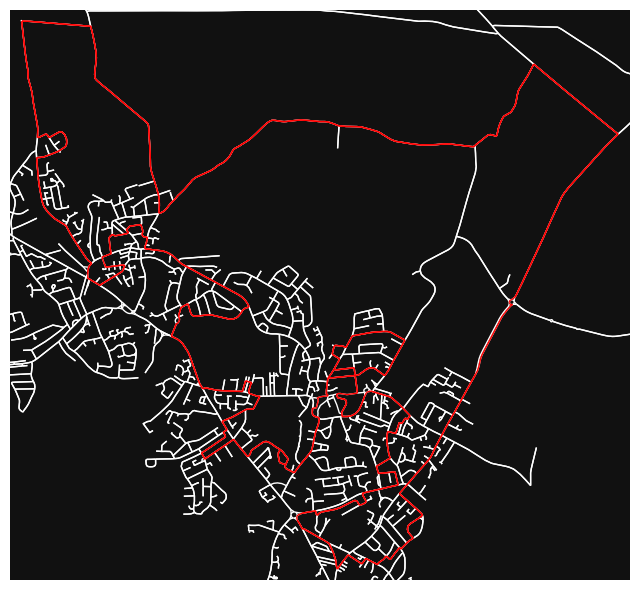

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [435]:
fig, ax = ox.plot_graph(cell_graphs[3], node_size=0, edge_linewidth=1, edge_color='w', show=False)
ox.plot_graph(route[0], node_size=0, edge_linewidth=1, edge_color='r',ax=ax, show=True)

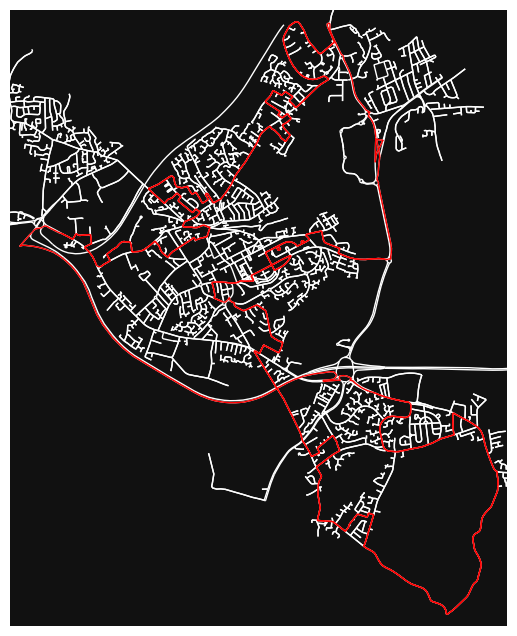

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [414]:
fig, ax = ox.plot_graph(cell_graphs[9], node_size=0, edge_linewidth=1, edge_color='w', show=False)
ox.plot_graph(route[0][1], node_size=0, edge_linewidth=1, edge_color='r', ax=ax, show=False)
ox.plot_graph(route[0][0], node_size=0, edge_linewidth=1, edge_color='r',ax=ax, show=True)

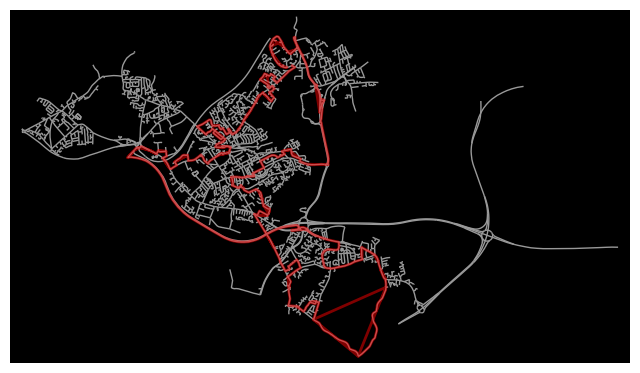

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [395]:
ox.plot_graph_route(cell_graphs[9].to_undirected(), route[0], route_color='r', route_linewidth=2, node_size=0, bgcolor='k', orig_dest_size=0)

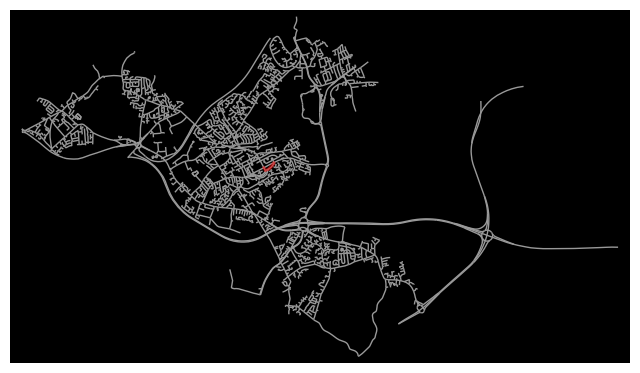

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [311]:
ox.plot_graph_route(cell_graphs[9].to_undirected(), route[0][1], route_color='r', route_linewidth=2, node_size=0, bgcolor='k', orig_dest_size=0)

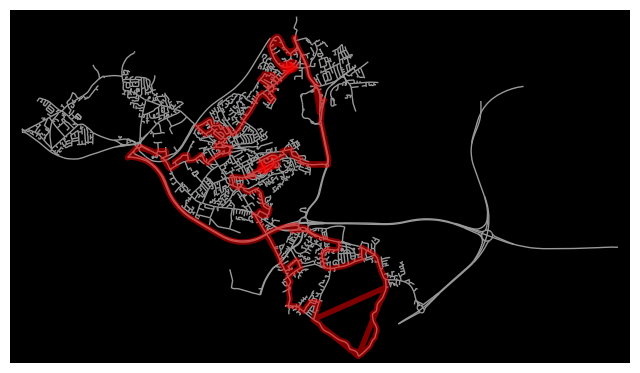

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [308]:
ox.plot_graph_routes(cell_graphs[9].to_undirected(), route[0], route_color='r', route_linewidth=2, node_size=0, bgcolor='k')

TypeError: OutEdgeView.__call__() got an unexpected keyword argument 'keys'

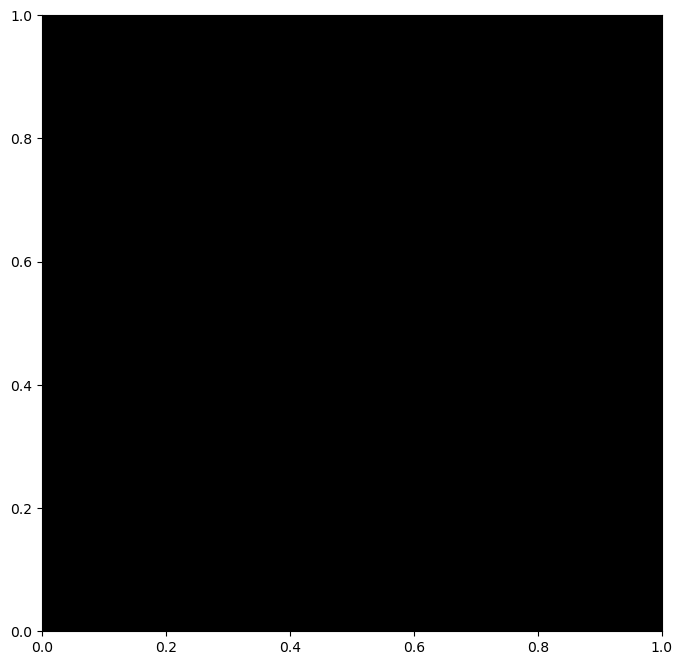

In [35]:
ox.plot_graph_route(cell_graphs[0].to_undirected(), cycle, route_color='r', route_linewidth=6, node_size=0, bgcolor='k')

In [1338]:
def find_route(cell_graph):
    cycles = nx.simple_cycles(cell_graph)
    route = {}
    max_length = 0
    start_time = time.time()
    for cycle in cycles:
        cycle.append(cycle[0])
        length = 0
        for i in range(len(cycle)-1):
            length += cell_graph.get_edge_data(cycle[i], cycle[i+1])[0]["length"]
        
        # 1/1
        # if length >= 41500 and length <= 42000:
        if length >= 41000 and length <= 42500:
            if length > max_length:
                max_length = length
                route['cycle'] = cycle
                route['length'] = length
                route['color'] = 'orange'
                route['km'] = '42'
        
        # 1/1.25
        # elif length >= 33200 and length <= 34000:
        elif length >= 33200 and length <= 33600:
            if length > max_length:
                max_length = length
                route['cycle'] = cycle
                route['length'] = length
                route['color'] = 'dodgerblue'
                route['km'] = '33.6'

        # 1/1.5
        # elif length >= 27667 and length <= 28333:
        elif length >= 27667 and length <= 28000:
            if length > max_length:
                max_length = length
                route['cycle'] = cycle
                route['length'] = length
                route['color'] = 'mediumpurple'
                route['km'] = '28'

        # 1/2
        # elif length >= 20750 and length <= 21250:
        elif length >= 20750 and length <= 21000:
            if length > max_length:
                max_length = length
                route['cycle'] = cycle
                route['length'] = length
                route['color'] = 'w'
                route['km'] = '21'

        # 1/4
        # elif length >= 10375 and length <= 10650:
        elif length >= 10375 and length <= 10500:
            if length > max_length:
                max_length = length
                route['cycle'] = cycle
                route['length'] = length
                route['color'] = 'sienna'
                route['km'] = '10.5'
        
        # 1/7
        # elif length >= 5829 and length <= 6071:
        elif length >= 5829 and length <= 6000:
            if length > max_length:
                max_length = length
                route['cycle'] = cycle
                route['length'] = length
                route['color'] = 'hotpink'
                route['km'] = '6'
        
        if time.time() - start_time > 40:
            print(max_length)
            return route
        

In [1340]:
routes = {}
for i in range(len(cell_graphs)):
    print("cell", i)
    route = find_route(cell_graphs[i])
    if route:
        routes[i] = route

cell 0
33598.686000000016
cell 1
20999.925000000007
cell 2
42456.352999999996
cell 3
27999.988999999994
cell 4
27988.479
cell 5
42434.35799999999
cell 6
0
cell 7
10495.843000000003
cell 8
5999.957000000002
cell 9
0


In [ ]:
routes.keys()

dict_keys([0, 1, 2, 3, 4, 5, 7, 8])

In [ ]:
def find_more_than_42_route(cell_graph):
    cycles = nx.simple_cycles(cell_graph)
    route = {}
    for cycle in cycles:
        cycle.append(cycle[0])
        length = 0
        for i in range(len(cycle)-1):
            length += cell_graph.get_edge_data(cycle[i], cycle[i+1])[0]["length"]
        
        if length > 42000:
            route['cycle'] = cycle
            route['length'] = length
            route['color'] = 'cyan'
            route['km'] = '>42'

            print(length)
            return route

In [ ]:
route_6 = find_more_than_42_route(cell_graphs[6])
route_9 = find_more_than_42_route(cell_graphs[9])
routes.update({6: route_6, 9: route_9})

65896.59999999998
48457.52699999992


In [ ]:
routes.keys()

dict_keys([0, 1, 2, 3, 4, 5, 7, 8, 6, 9])

In [ ]:
all_routes = [value['cycle'] for value in routes.values()]
all_route_colors = [value['color'] for value in routes.values()]

len(all_routes)

10

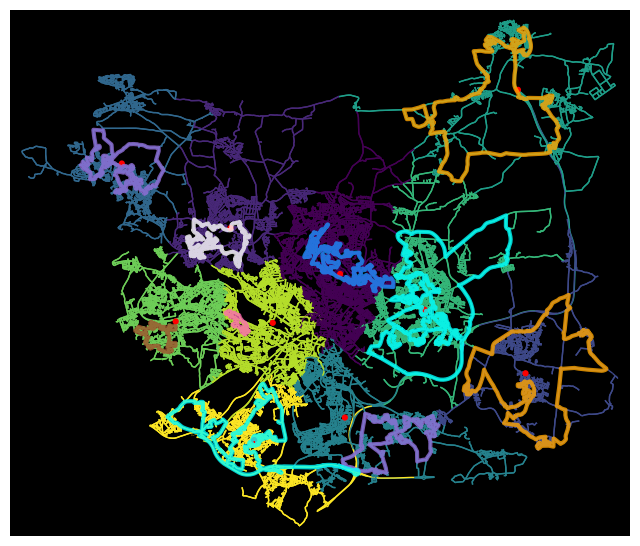

In [ ]:
fig, ax = ox.plot_graph(leeds_graph, edge_color=edge_colors, node_color=node_colors, node_size=20, bgcolor ='k', show=False)
ox.plot_graph_routes(leeds_graph, all_routes, route_colors=all_route_colors, route_linewidths=3, orig_dest_size=0, route_alpha=0.8, ax=ax)
plt.show()

In [ ]:
route_5 = find_route(cell_graphs[5])

41499.77099999999


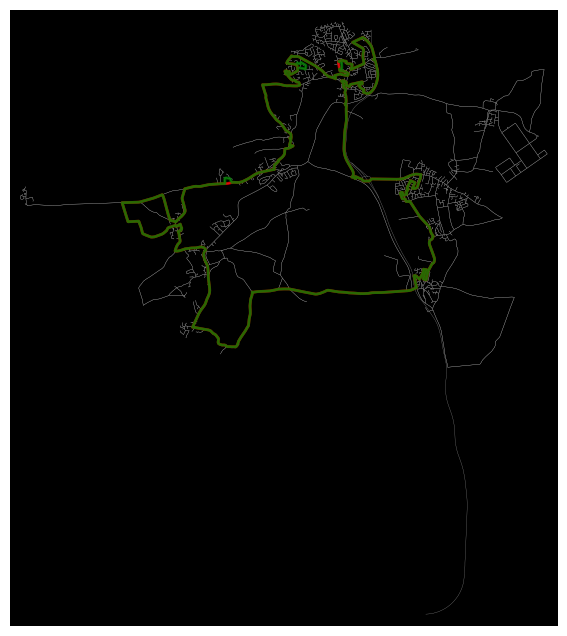

In [ ]:
fig, ax = ox.plot_graph(cell_graphs[5], node_size=0, bgcolor ='k', show=False, edge_linewidth=0.2)
ox.plot_graph_routes(cell_graphs[5], [route_5['cycle'], all_routes[5]], route_colors=['r','g'], route_linewidths=2, orig_dest_size=0, route_alpha=0.8, ax=ax)
plt.show()

# Task D

In [ ]:
from prov.model import ProvDocument, Namespace, Literal

# Define the namespaces
EX = Namespace('ex', 'http://example.com/')
PROV = Namespace('prov', 'http://www.w3.org/ns/prov#')

# Create a new provenance document
doc = ProvDocument()

# Define the entities
road_segment = doc.entity(EX['road_segment'], {'prov:type': 'ex:RoadSegment'})
accident = doc.entity(EX['accident'], {'prov:type': 'ex:Accident'})
marathon = doc.entity(EX['marathon'], {'prov:type': 'ex:Marathon'})

# Define the activities
accident_report = doc.activity(EX['accident_report'], other_attributes={'prov:type': 'ex:AccidentReport'})
marathon_organization = doc.activity(EX['marathon_organization'], other_attributes={'prov:type': 'ex:MarathonOrganization'})

# Define the agents
leeds_city_council = doc.agent(EX['leeds_city_council'], {'prov:type': 'ex:LeedsCityCouncil'})
emergency_services = doc.agent(EX['emergency_services'], {'prov:type': 'ex:EmergencyServices'})
marathon_organizers = doc.agent(EX['marathon_organizers'], {'prov:type': 'ex:MarathonOrganizers'})

# Define the relationships between the entities, activities, and agents
doc.wasGeneratedBy(accident, accident_report, other_attributes={'prov:activity': accident_report})
doc.wasGeneratedBy(marathon, marathon_organization, other_attributes={'prov:activity': marathon_organization})

doc.wasAttributedTo(leeds_city_council, accident_report)
doc.wasAttributedTo(emergency_services, accident_report)
doc.wasAttributedTo(marathon_organizers, marathon_organization)

doc.used(accident_report, road_segment)
doc.used(marathon_organization, road_segment)

# visualize the graph
from prov.dot import prov_to_dot
dot = prov_to_dot(doc)
dot.write_png('PROV.png')

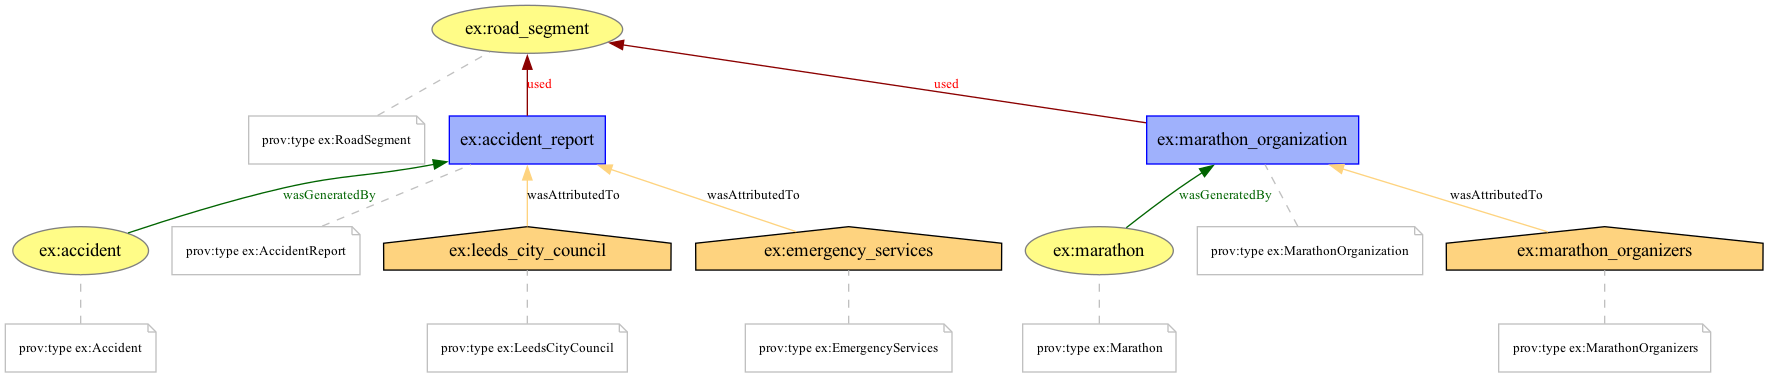

In [ ]:
from IPython.display import Image
Image('PROV.png')